In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
import HDF5
using Optim

In [2]:
include("../model-41/likelihood.jl")
include("../model-41/utill_model.jl")
include("../utill.jl")

plot_projections (generic function with 1 method)

In [3]:
function hist_2d(smpls, dim_1, dim_2; nbins=35, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [4]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

function trunc_norm(m, sgm; alpha=2)
    return truncated(Normal(m, sgm), m - alpha*sgm, m + alpha*sgm)
end

prior_11 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [0.1, 0.1],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [2.0, 2.0],
        mixt_pow =  1.0 , 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [2.9], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
); 

prior_12 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [0.1, 0.1],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [2.0, 2.0],
        mixt_pow =  1.0 , 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [2.9], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
        psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
        cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
        cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
);

prior_13 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [0.1, 0.1],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [2.0, 2.0],
        mixt_pow =  1.0 , 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [2.9], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [trunc_norm(1, 0.5), trunc_norm(1, 1), trunc_norm(1, 0.5)], 
        resy = [trunc_norm(1, 0.5), trunc_norm(1, 1), trunc_norm(1, 0.5)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
        psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
        cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
        cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
); 

prior_21 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.55 .. 1.0, 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
)

prior_22 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.55 .. 1.0, 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
        psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
        cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
        cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
)

prior_23 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.55 .. 1.0, 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [trunc_norm(1, 0.5), trunc_norm(1, 1), trunc_norm(1, 0.5)], 
        resy = [trunc_norm(1, 0.5), trunc_norm(1, 1), trunc_norm(1, 0.5)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
        psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
        cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
        cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
);

In [5]:
FPATH = "../../data/sampling_results/Benchmark-12/"

"../../data/sampling_results/Benchmark-12/"

In [6]:
smpl_tmp = bat_read(FPATH*"samples-11.hdf5").result
samples_11 = varshape(prior_11).(smpl_tmp)

smpl_tmp = bat_read(FPATH*"samples-12.hdf5").result
samples_12 = varshape(prior_12).(smpl_tmp)

smpl_tmp = bat_read(FPATH*"samples-13.hdf5").result
samples_13 = varshape(prior_13).(smpl_tmp);

smpl_tmp = bat_read(FPATH*"samples-21.hdf5").result
samples_21 = varshape(prior_21).(smpl_tmp)

smpl_tmp = bat_read(FPATH*"samples-22.hdf5").result
samples_22 = varshape(prior_22).(smpl_tmp)

smpl_tmp = bat_read(FPATH*"samples-23.hdf5").result
samples_23 = varshape(prior_23).(smpl_tmp);

In [7]:
[size(flatview(unshaped.(samples_11.v))), size(flatview(unshaped.(samples_12.v))), size(flatview(unshaped.(samples_13.v)))]

3-element Array{Tuple{Int64,Int64},1}:
 (21, 500598)
 (29, 456361)
 (35, 432395)

In [8]:
[size(flatview(unshaped.(samples_21.v))), size(flatview(unshaped.(samples_22.v))), size(flatview(unshaped.(samples_23.v)))]

3-element Array{Tuple{Int64,Int64},1}:
 (27, 472740)
 (35, 451600)
 (41, 406279)

In [9]:
[length(samples_11), length(samples_12), length(samples_13), length(samples_21), length(samples_22), length(samples_23)]

6-element Array{Int64,1}:
 500598
 456361
 432395
 472740
 451600
 406279

In [10]:
function plot_contour(ax, hist; kwargs...)
    ax.contour(midpoints(hist.edges[1]), midpoints(hist.edges[2]), hist.weights', 
        levels=range(minimum(hist.weights'), maximum(hist.weights'), length=8)[2:end]; #corner_mask= true,
        kwargs..., antialiased=true) 
end

function plot_contourf(ax, hist; kwargs...)
    ax.contourf(midpoints(hist.edges[1]), midpoints(hist.edges[2]), hist.weights', 
        levels=range(minimum(hist.weights'), maximum(hist.weights'), length=8)[2:end]; #corner_mask= true,
        kwargs..., antialiased=true) 
end

plot_contourf (generic function with 1 method)

In [11]:
hist_11 = hist_2d(samples_11, 1,2)
hist_12 = hist_2d(samples_12, 1,2)
hist_13 = hist_2d(samples_13, 1,2)

hist_211 = hist_2d(samples_21, 1,2)
hist_212 = hist_2d(samples_21, 3,4)

hist_221 = hist_2d(samples_22, 1,2)
hist_222 = hist_2d(samples_22, 3,4)

hist_231 = hist_2d(samples_23, 1,2)
hist_232 = hist_2d(samples_23, 3,4);

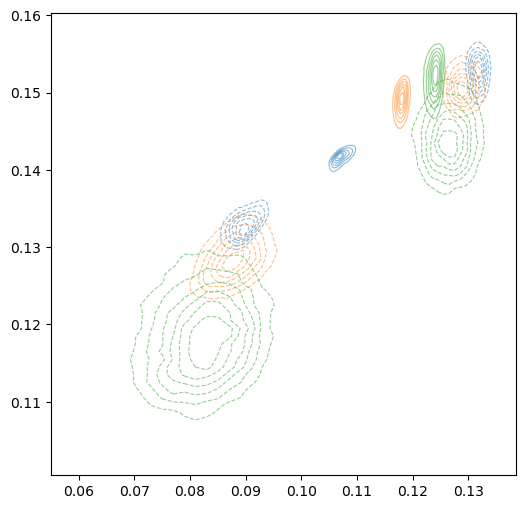

PyObject <matplotlib.contour.QuadContourSet object at 0x7f7e1ef03490>

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plot_contour(ax, hist_11, colors=:C0, linewidths=0.8, alpha=0.5, )
plot_contour(ax, hist_12, colors=:C1, linewidths=0.8, alpha=0.5,)
plot_contour(ax, hist_13, colors=:C2, linewidths=0.8, alpha=0.5,)

plot_contour(ax, hist_211, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_212, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_221, colors=:C1, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_222, colors=:C1, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_231, colors=:C2, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_232, colors=:C2, linewidths=0.8, alpha=0.5, linestyles=:dashed)

# ax.set_xlim(0.02, 0.2)
# ax.set_ylim(0.02, 0.2)

# Uncertainty Check: 

In [13]:
function def_datasets(samples_init, samples_ext, indid; nsampls=60)
    samples_init = bat_sample(samples_init, OrderedResampling(nsamples=nsampls)).result
    samples_init = flatview(unshaped.(samples_init.v))
    samples_ext = bat_sample(samples_ext, OrderedResampling(nsamples=nsampls)).result
    samples_ext = flatview(unshaped.(samples_ext.v))
    
    samples_init = samples_init[indid,:] 
    samples_ext = samples_ext[indid,:] 
    
    return samples_init, samples_ext
end

def_datasets (generic function with 1 method)

In [14]:
tmp_1 = def_datasets(samples_21, samples_23, [1,2,3,4,5,6,7,8,9,10,11]);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/KbWVg/src/algotypes/bat_default.jl:44


In [15]:
function cost_func(params, samples_init, samples_ext)
    
    cost_total = 0.0
    npars = Int(length(params)/2)
    mean = params[1:npars]
    cv_mat = Diagonal(params[npars+1:end].^2) 
    
    for i in eachcol(samples_ext)
        ll_tmp = 0.0
        for j in eachcol(samples_init)
            ll_tmp += logpdf(MvNormal(j.-mean, cv_mat), i) 
        end
        cost_total += ll_tmp
    end
    return -cost_total
end

eval_cost(x) = cost_func(x, tmp_1[1], tmp_1[2])

eval_cost (generic function with 1 method)

In [16]:
@time eval_cost(rand(22))

  0.232030 seconds (436.63 k allocations: 23.661 MiB)


7.297110746606424e6

In [ ]:
lower = [repeat([-10.,], 11); repeat([0.,], 11)]
upper = [repeat([10.,], 11); repeat([10.,], 11)]
initial_x = repeat([0.1,], 22)
inner_optimizer = GradientDescent()

@time result = optimize(eval_cost, lower, upper, initial_x)

min_vals = Optim.minimizer(result)

In [ ]:
Optim.f_calls(result)

In [ ]:
npars_tmp = Int(length(min_vals)/2)
mean_tmp = min_vals[1:npars_tmp] * 0.0
minimized_cv = Diagonal(min_vals[npars_tmp+1:end].^2) 

tmp_2 = def_datasets(samples_21, samples_23, [1,2,3,4,5,6,7,8,9,10,11], nsampls=10^4);

samples_corrected = [rand(MvNormal(i .- mean_tmp , minimized_cv)) for i in eachcol(tmp_2[1])];
samples_corrected = hcat(samples_corrected...);

In [ ]:
hist_new_1 = fit(Histogram, (samples_corrected[1,:],samples_corrected[2,:]), nbins=20)
hist_new_1 = normalize(hist_new_1, mode=:pdf) 

hist_new_2 = fit(Histogram, (samples_corrected[3,:],samples_corrected[4,:]), nbins=20)
hist_new_2 = normalize(hist_new_2, mode=:pdf) ;

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


plot_contour(ax, hist_new_1, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_new_2, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_211, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_212, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_231, colors=:gray, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_232, colors=:gray, linewidths=0.8, alpha=0.5, linestyles=:dashed)

# ax.set_xlim(0.02, 0.2)
# ax.set_ylim(0.02, 0.2)